<a href="https://colab.research.google.com/github/Parthasarathi009/Project-Predicting-Movies-User-Ratings-with-IMDb-Attributes/blob/master/Movie_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-gpu
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras

2.2.0


In [ ]:
import pandas as pd
import numpy as np
from numpy import median
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("white")
pd.set_option('display.max_columns', 50)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def load_data(filepath):
  '''
  Loads csv file (with header) from filepath
  '''
  return pd.read_csv(filepath)


In [ ]:
filepath='https://raw.githubusercontent.com/sundeepblue/movie_rating_prediction/master/movie_metadata.csv'

dataset=load_data(filepath)
dataset.head(2)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0


### **Obversations & ideas for data preprocessing from Visual inspection**

- ***Check for presence of Null values***

- scale all the numeical data between (0 to 1) to normalise
- genres, plot_keywords; split the text and perfrorm one-hot encoding
- names(director, actors), language, country one-hot encoding

###### **Drop Column**
- movie_imdb_link : IT contains the link of the IMDb page

In [ ]:
print("The shape of the raw Dataset{}".format(dataset.shape))
print(dataset.columns)
print(dataset.dtypes)

The shape of the raw Dataset(5043, 28)
Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')
color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_na

- Facebook likes data types are float, should be integer

In [ ]:
dataset.info

<bound method DataFrame.info of       color      director_name  num_critic_for_reviews  duration  \
0     Color      James Cameron                   723.0     178.0   
1     Color     Gore Verbinski                   302.0     169.0   
2     Color         Sam Mendes                   602.0     148.0   
3     Color  Christopher Nolan                   813.0     164.0   
4       NaN        Doug Walker                     NaN       NaN   
...     ...                ...                     ...       ...   
5038  Color        Scott Smith                     1.0      87.0   
5039  Color                NaN                    43.0      43.0   
5040  Color   Benjamin Roberds                    13.0      76.0   
5041  Color        Daniel Hsia                    14.0     100.0   
5042  Color           Jon Gunn                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                         0.0                   855.0  Joel David Moore   
1

In [ ]:
target=dataset["imdb_score"]
dataset.drop(["movie_imdb_link"], inplace=True, axis=1)

In [ ]:
def getfeatures(dataset):
  numeric_features=dataset._get_numeric_data().columns.values.tolist()
  text_features=dataset.columns.values.tolist()
  text_features=[i for i in text_features if i not in numeric_features]

  string_features=["movie_title", "plot_keywords","genres"]

  categorical_features=[i for i in text_features if i not in string_features]

  ### Title_year  is categorical
  numeric_features.remove("title_year") 
  categorical_features.append("title_year")

  numeric_features.remove("imdb_score") 

  return numeric_features, categorical_features, string_features

In [ ]:
numeric_features, categorical_features, string_features = getfeatures(dataset)

print("\n numeric_features\n",numeric_features)
print("\ncategorical_features\n",categorical_features)
print("\n string_features\n",string_features)



 numeric_features
 ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'budget', 'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes']

categorical_features
 ['color', 'director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'language', 'country', 'content_rating', 'title_year']

 string_features
 ['movie_title', 'plot_keywords', 'genres']


### Data Exploration Graphs before any feature Enginering

Text(0.5, 1.0, 'Distribution of IMDb Score with median score 6.6')

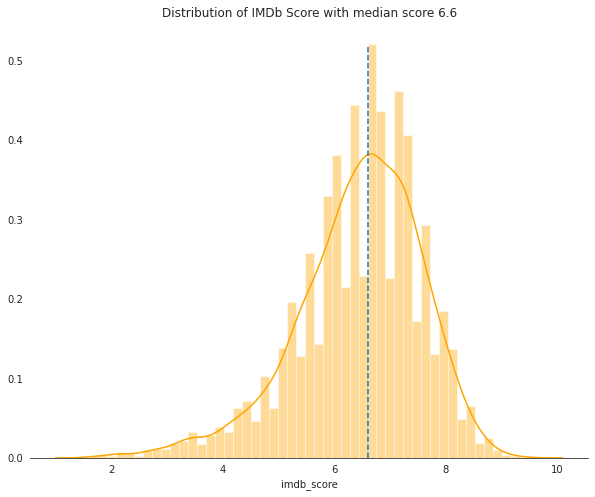

In [ ]:
# Overview of imdb score
plt.figure(figsize=(10,8))
sns.distplot(target, color='orange')
plt.axvline(target.median(), ymax= 0.95, linestyle='--')
sns.despine(left=True)
plt.title("Distribution of IMDb Score with median score "+str(target.median()))

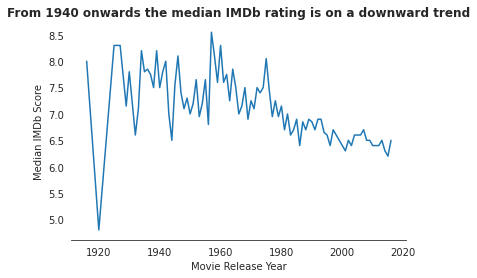

In [ ]:
sns.lineplot(x='title_year',y='imdb_score',data=dataset, estimator=median, ci=None)
plt.title("From 1940 onwards the median IMDb rating is on a downward trend",  fontsize=12,fontweight='semibold')
plt.xlabel("Movie Release Year")
plt.ylabel("Median IMDb Score")
sns.despine(left=True)

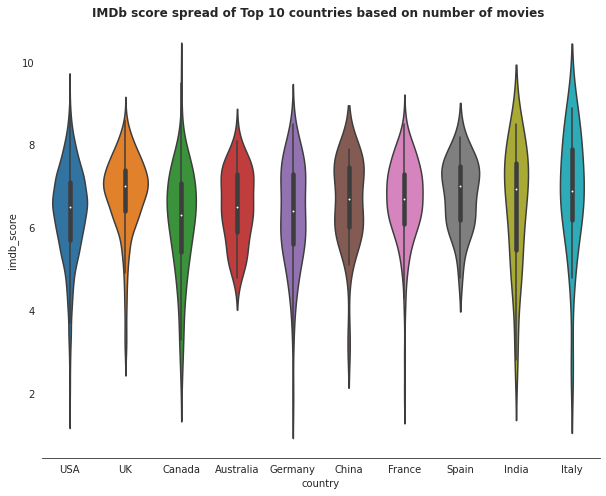

In [ ]:
# Top10 country score spread
top10country=dataset.country.value_counts().head(10).index.tolist()
plt.figure(figsize=(10,8))
sns.violinplot(x='country',y='imdb_score', data=dataset[dataset.country.isin(top10country)])
plt.title("IMDb score spread of Top 10 countries based on number of movies ",fontsize=12,fontweight='semibold')
sns.despine(left=True)

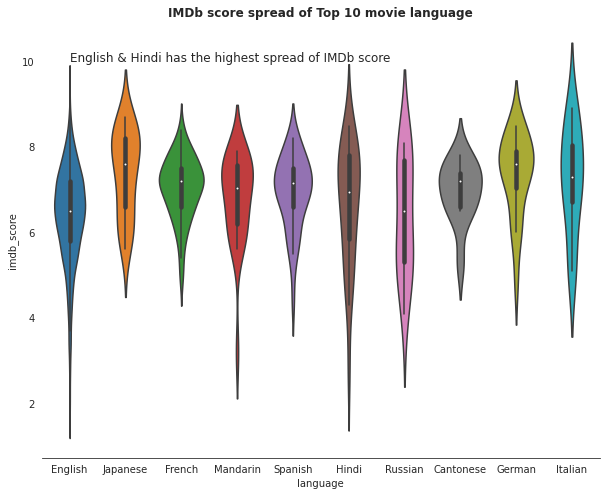

In [ ]:
# language with highest rating
top10language=dataset.language.value_counts().head(10).index.tolist()
plt.figure(figsize=(10,8))
sns.violinplot(x='language',y='imdb_score', data=dataset[dataset.language.isin(top10language)])
plt.title("IMDb score spread of Top 10 movie language",fontsize=12,fontweight='semibold')
plt.text(0,10,"English & Hindi has the highest spread of IMDb score",fontsize=12)
sns.despine(left=True)

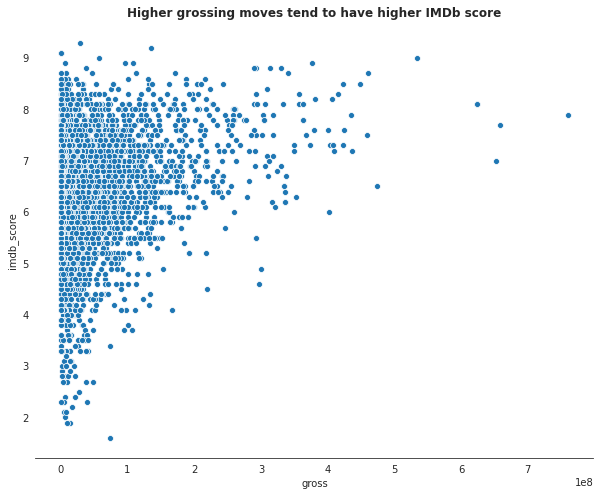

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='gross',y='imdb_score',data=dataset)
plt.title("Higher grossing moves tend to have higher IMDb score",fontsize=12,fontweight='semibold')
sns.despine(left=True)

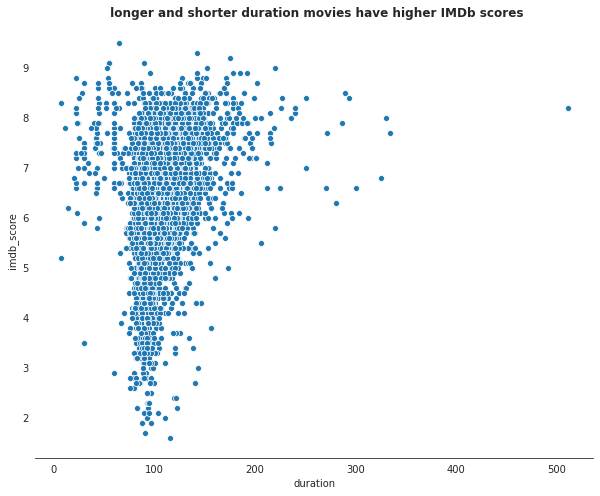

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='duration',y='imdb_score',data=dataset)
plt.title(" longer and shorter duration movies have higher IMDb scores",fontsize=12,fontweight='semibold')
sns.despine(left=True)

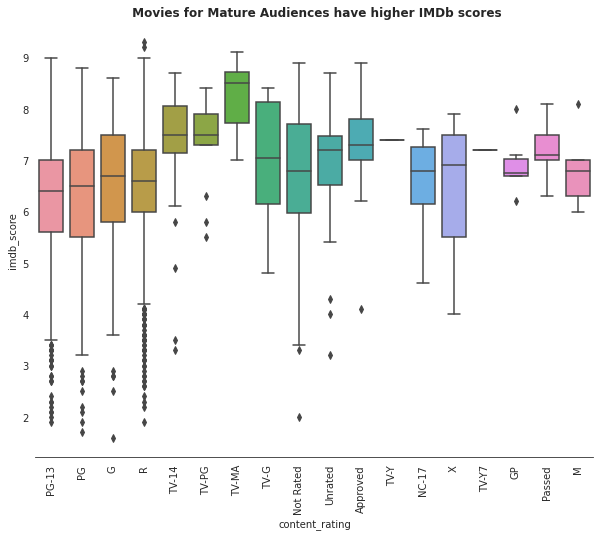

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='content_rating',y='imdb_score',data=dataset)
plt.title(" Movies for Mature Audiences have higher IMDb scores",fontsize=12,fontweight='semibold')
plt.xticks(rotation=90)
sns.despine(left=True)

### Numerical Features Deep Dive 

In [ ]:
corrmatrix=dataset[numeric_features].corr()

Text(0.5, 1.0, "'cast_total_facebook_likes' highly correlated with 'actor_1_facebook_likes' \n 'num _user_for_review' hihgly correlated with 'num_voted_users' \n 'num_critic_for_reviews' has high correlation with multiple variables ")

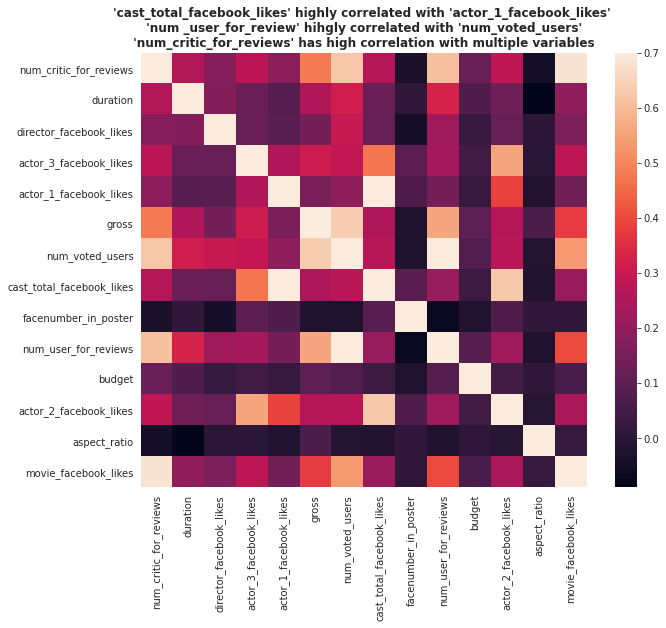

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corrmatrix,vmax=.7)
plt.title("'cast_total_facebook_likes' highly correlated with 'actor_1_facebook_likes' \n 'num _user_for_review' hihgly correlated with 'num_voted_users' \n 'num_critic_for_reviews' has high correlation with multiple variables ", fontsize=12,fontweight='semibold')

In [ ]:
print(corrmatrix[corrmatrix>0.6][['cast_total_facebook_likes','actor_2_facebook_likes']] )
print("\n ## Drop the 'cast_total_facebook_likes' ## ")

                           cast_total_facebook_likes  actor_2_facebook_likes
num_critic_for_reviews                           NaN                     NaN
duration                                         NaN                     NaN
director_facebook_likes                          NaN                     NaN
actor_3_facebook_likes                           NaN                     NaN
actor_1_facebook_likes                      0.951661                     NaN
gross                                            NaN                     NaN
num_voted_users                                  NaN                     NaN
cast_total_facebook_likes                   1.000000                0.628404
facenumber_in_poster                             NaN                     NaN
num_user_for_reviews                             NaN                     NaN
budget                                           NaN                     NaN
actor_2_facebook_likes                      0.628404                1.000000

In [ ]:
print(corrmatrix[corrmatrix>0.6][['num_critic_for_reviews','num_voted_users','num_user_for_reviews','movie_facebook_likes']] )
print("\n -Drop 'num_critic_for_reviews' \n -create new feature with average of 'num_voted_users','num_user_for_reviews'  ")

                           num_critic_for_reviews  num_voted_users  \
num_critic_for_reviews                   1.000000         0.624943   
duration                                      NaN              NaN   
director_facebook_likes                       NaN              NaN   
actor_3_facebook_likes                        NaN              NaN   
actor_1_facebook_likes                        NaN              NaN   
gross                                         NaN         0.637271   
num_voted_users                          0.624943         1.000000   
cast_total_facebook_likes                     NaN              NaN   
facenumber_in_poster                          NaN              NaN   
num_user_for_reviews                     0.609387         0.798406   
budget                                        NaN              NaN   
actor_2_facebook_likes                        NaN              NaN   
aspect_ratio                                  NaN              NaN   
movie_facebook_likes

In [ ]:
dataset['num_user_voted_reviews']= (dataset.num_voted_users+dataset.num_user_for_reviews)/2
numeric_features.append("num_user_voted_reviews")

removelist=['num_voted_users','num_user_for_reviews','num_critic_for_reviews','cast_total_facebook_likes']
dataset.drop(removelist, axis=1, inplace=True)
for feat in removelist:
  numeric_features.remove(feat)

print(numeric_features)


['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes', 'num_user_voted_reviews']


### Numeric features : imputation

In [ ]:
imput=SimpleImputer(strategy="most_frequent")
dataset[numeric_features]=imput.fit_transform(dataset[numeric_features])

In [ ]:
for feat in categorical_features:
  dataset=pd.concat([dataset, pd.get_dummies(dataset[feat], prefix=feat, dummy_na=True)],axis=1)

dataset.drop(categorical_features,inplace=True, axis=1)
print(dataset.shape)

(5043, 11295)


In [ ]:
dataset=pd.concat([dataset, dataset.plot_keywords.str.get_dummies(sep='|')],axis=1)
dataset=pd.concat([dataset, dataset.genres.str.get_dummies(sep='|')],axis=1)

dataset.drop(['genres','plot_keywords'], axis=1,inplace=True)
print(dataset.shape)

(5043, 19405)


In [ ]:
dataset.head(3)

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,facenumber_in_poster,budget,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,num_user_voted_reviews,color_ Black and White,color_Color,color_nan,director_name_A. Raven Cruz,director_name_Aaron Hann,director_name_Aaron Schneider,director_name_Aaron Seltzer,director_name_Abel Ferrara,director_name_Adam Brooks,director_name_Adam Carolla,director_name_Adam Goldberg,director_name_Adam Green,...,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,178.0,0.0,855.0,1000.0,760505847.0,Avatar,0.0,237000000.0,936.0,7.9,1.78,33000.0,444629.0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,169.0,563.0,1000.0,40000.0,309404152.0,Pirates of the Caribbean: At World's End,0.0,300000000.0,5000.0,7.1,2.35,0.0,236229.0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,148.0,0.0,161.0,11000.0,200074175.0,Spectre,1.0,245000000.0,393.0,6.8,2.35,85000.0,138431.0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#dataset[dataset.movie_title.str.contains(':')].movie_title
#Series are captured using ':' . i.e. Avengers: Age of Ultron
dataset['movie_title'].str.split(':',n = 1, expand = True).head(5)

,0,1
0,Avatar,None
1,Pirates of the Caribbean,At World's End
2,Spectre,None
3,The Dark Knight Rises,None
4,Star Wars,Episode VII - The Force Awakens


In [ ]:
# Change movie_title to movie series name
dataset['movie_title']=dataset['movie_title'].str.split(':',n = 1, expand = True)[0]
dataset['movie_title'].head(5)

0                     Avatar 
1    Pirates of the Caribbean
2                    Spectre 
3      The Dark Knight Rises 
4                   Star Wars
Name: movie_title, dtype: object

In [ ]:
#dataset.movie_title.str.get_dummies()
dataset=pd.concat([dataset, dataset.movie_title.str.get_dummies()],axis=1)

dataset.drop('movie_title', axis=1,inplace=True)
print(dataset.shape)

(5043, 24258)


### ***Failed Approach #1:*** 

Models( Neural network and Traditional Ensemble) are created by taking all the features as inputs, but the accuracy was very very low or zero. 

Hense, 20 prominant categrical features are selected to be used with numerical features for the model. 

In [ ]:
cat_dummies=[i for i in dataset.columns.values.tolist() if i not in numeric_features]
cat_dummies=[i for i in cat_dummies if i not in string_features]
#cat_dummies.remove("title_year")
cat_dummies.remove("imdb_score")
cat_dummies[-5:]

['[Rec]\xa0', 'eXistenZ\xa0', 'xXx', 'xXx\xa0', 'Æon Flux\xa0']

In [ ]:
string_features

['movie_title', 'plot_keywords', 'genres']

In [ ]:
import operator
from scipy.stats import pearsonr

correl={}

for f in cat_dummies:
    correl[f]=pearsonr(dataset[f], target)
sorted_cor = sorted(correl.items(), key=operator.itemgetter(1), reverse=True)

print (sorted_cor[0:10])
print("")
print (sorted_cor[-10:])

[('Drama', (0.29422941532885605, 2.897036523179112e-101)), ('Biography', (0.1563098474509413, 5.971511684840047e-29)), ('title_year_nan', (0.14750633910264221, 6.2782353245904e-26)), ('color_ Black and White', (0.14511424068479978, 3.870767484243074e-25)), ('director_name_nan', (0.14265081749456862, 2.4404929097514546e-24)), ('History', (0.11796197270495679, 4.3063733951378196e-17)), ('War', (0.1172785764922972, 6.53150104277031e-17)), ('country_UK', (0.10440506080030316, 1.0639360612090511e-13)), ('Documentary', (0.10285853660931761, 2.4426414031850694e-13)), ('content_rating_TV-MA', (0.10140154955889742, 5.284971995462917e-13))]

[('director_name_Jason Friedberg', (-0.09622248026201692, 7.523046586024538e-12)), ('box office flop', (-0.09625039771280854, 7.418836459513909e-12)), ('Action', (-0.09787152587552678, 3.2779635827784732e-12)), ('critically bashed', (-0.10119574250537411, 5.88855912448143e-13)), ('content_rating_PG-13', (-0.10481909154206603, 8.499266605835058e-14)), ('count

In [ ]:
predictors=["Drama","Biography","director_facebook_likes", "title_year_nan","color_ Black and White",
            "director_name_nan","History","War", "country_UK","Documentary", "content_rating_TV-MA",
            "director_name_Jason Friedberg","box office flop","Action","critically bashed","content_rating_PG-13", "country_USA","color_Color", "language_English","Comedy","Horror"]

Text(0.5, 1.0, 'Correlation matrix for all relevant predictors \n Remove "color_Black and White" &"title_year_nan"')

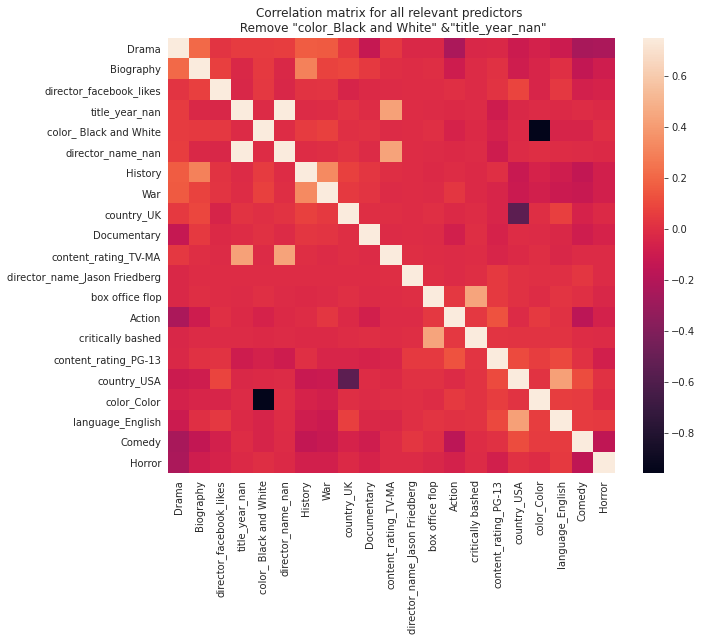

In [ ]:
corrmat = dataset[predictors].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corrmat, vmax=.75)
plt.title( 'Correlation matrix for all relevant predictors \n Remove "color_Black and White" &"title_year_nan"')

In [ ]:
predictors.remove('color_ Black and White')
predictors.remove('title_year_nan')
predictors

['Drama',
 'Biography',
 'director_facebook_likes',
 'director_name_nan',
 'History',
 'War',
 'country_UK',
 'Documentary',
 'content_rating_TV-MA',
 'director_name_Jason Friedberg',
 'box office flop',
 'Action',
 'critically bashed',
 'content_rating_PG-13',
 'country_USA',
 'color_Color',
 'language_English',
 'Comedy',
 'Horror']

In [ ]:
numeric_features

['duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'gross',
 'facenumber_in_poster',
 'budget',
 'actor_2_facebook_likes',
 'aspect_ratio',
 'movie_facebook_likes',
 'num_user_voted_reviews']

In [ ]:
selectedfeatures=predictors+numeric_features
selectedfeatures

['Drama',
 'Biography',
 'director_facebook_likes',
 'director_name_nan',
 'History',
 'War',
 'country_UK',
 'Documentary',
 'content_rating_TV-MA',
 'director_name_Jason Friedberg',
 'box office flop',
 'Action',
 'critically bashed',
 'content_rating_PG-13',
 'country_USA',
 'color_Color',
 'language_English',
 'Comedy',
 'Horror',
 'duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'gross',
 'facenumber_in_poster',
 'budget',
 'actor_2_facebook_likes',
 'aspect_ratio',
 'movie_facebook_likes',
 'num_user_voted_reviews']

#### Train & Test Data Preparation

In [ ]:
X_train_full,X_test,y_train_full,y_test=train_test_split(dataset[selectedfeatures],target,test_size=0.25, random_state=40)

X_train,X_valid,y_train,y_valid=train_test_split(X_train_full,y_train_full,test_size=0.25, random_state=40)

print( "shape of X_train_full:",X_train_full.shape)
print( "shape of X_test:",X_test.shape)
print( "shape of y_train_full:",y_train_full.shape)
print( "shape of y_test:",y_test.shape)
print( "shape of X_train:",X_train.shape)
print( "shape of X_valid:",X_valid.shape)
print( "shape of y_train:",y_train.shape)
print( "shape of y_valid:",y_valid.shape)

shape of X_train_full: (3782, 30)
shape of X_test: (1261, 30)
shape of y_train_full: (3782,)
shape of y_test: (1261,)
shape of X_train: (2836, 30)
shape of X_valid: (946, 30)
shape of y_train: (2836,)
shape of y_valid: (946,)


In [ ]:
scaler=StandardScaler()
X_train[numeric_features]=scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features]=scaler.transform(X_test[numeric_features])
X_valid[numeric_features]=scaler.transform(X_valid[numeric_features])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

### Neural Net (Sequential)

In [ ]:
params={
    "n_hidden":[1,2,3,4],
    "n_neurons": np.arange(10,300),
    "learning_rate":reciprocal(1e-3, 1)
}

In [ ]:
def create_model(n_hidden=1,n_neurons=100,learning_rate=1e-3,input_shape=X_train.shape[1:]):
  model= keras.models.Sequential()
  model.add(keras.layers.Dense(n_neurons,input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, kernel_initializer='he_normal'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dense(1))
  optimizer=keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=['accuracy'] )

  return model

In [ ]:
keras_clas= keras.wrappers.scikit_learn.KerasRegressor(create_model)

In [ ]:
rnd_cv= RandomizedSearchCV(keras_clas, params, n_iter=10)
rnd_cv.fit(X_train,y_train, epochs=30,
           validation_data=(X_valid, y_valid),
           callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/30
71/71 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/30
71/71 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/30
71/71 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/30
71/71 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/30
18/18 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 1/30
71/71 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/30
71/71 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/30
71/71 [==============================]

RuntimeError: ignored

### Neural Network was not able to predict the imdbscore. It seems NN is not able to handle too many sparse features

### Simple NN Model

In [ ]:
model_3=keras.models.Sequential(
    [keras.layers.Dense(300,input_shape=X_train.shape[1:]),
    keras.layers.Dense(100,activation='relu',kernel_initializer='he_normal'),
    keras.layers.Dense(100,activation='relu',kernel_initializer='he_normal'),
    keras.layers.Dense(1)
     ]
)

optimizer=keras.optimizers.SGD(learning_rate=1)
model_3.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=['accuracy'] )

In [ ]:
model_3.fit(X_train,y_train, epochs=300,
           validation_data=(X_valid, y_valid),
           callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/300
89/89 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/300
89/89 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/300
89/89 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/300
89/89 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/300
89/89 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


### For simple NN, the accuracy is still 0

### **RandomForest Regrssion**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFR=RandomForestRegressor(max_features="sqrt",random_state=42)
parameters={ "max_depth":[5,8,25], 
             "min_samples_split":[2,5,10], "n_estimators":[800,1200]}
gsearch = RandomizedSearchCV(RFR, parameters,random_state=42)
gsearch.fit(X_train,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='sqrt',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [ ]:
print("Best Parameters",gsearch.best_params_)
print("Best Score",gsearch.best_score_)

Best Parameters {'n_estimators': 1200, 'min_samples_split': 2, 'max_depth': 25}
Best Score 0.5064012527456392


In [ ]:
rfm=RandomForestRegressor(n_estimators=1200,max_depth=25,max_features="sqrt",random_state=42,n_jobs=-1,min_samples_split=2)
rfm.fit(X_train,y_train)
y_pred_rf=rfm.predict(X_test)
y_train_pred_rf=rfm.predict(X_train)

In [ ]:
for name,score in zip(X_train.columns,rfm.feature_importances_):
  print(name,score)

Drama 0.05337146279901098
Biography 0.006287865180162574
director_facebook_likes 0.04959883526906231
director_name_nan 0.00912199428786671
History 0.0021898465059061656
War 0.002125713449828925
country_UK 0.004595855718403823
Documentary 0.013643629579501425
content_rating_TV-MA 0.0013211671968169027
director_name_Jason Friedberg 0.0033771760407635886
box office flop 0.0023557957161136865
Action 0.012473939921086459
critically bashed 0.00368287623108234
content_rating_PG-13 0.017537009303831057
country_USA 0.00911682166603249
color_Color 0.005805252381668703
language_English 0.010849673159349227
Comedy 0.012155240572253253
Horror 0.019749852083688225
duration 0.09955719643654774
director_facebook_likes 0.05020943440982883
actor_3_facebook_likes 0.057640343177688444
actor_1_facebook_likes 0.05505988325010954
gross 0.06313224128117748
facenumber_in_poster 0.02676857597943079
budget 0.06386451626337511
actor_2_facebook_likes 0.055138332293441096
aspect_ratio 0.024594460110485605
movie_fac

In [ ]:
print("Print R2 score of Test:",r2_score(y_test, y_pred_rf))
print("Print R2 Score of Training",r2_score(y_train,y_train_pred_rf))
print("The Randomforest is over fitting ")

Print R2 score of Test: 0.5600780608628007
Print R2 Score of Training 0.9344666795578979
The Randomforest is over fitting 


In [ ]:
print("Print mean_squared_error of Test:",mean_squared_error(y_test, y_pred_rf))
print("Print mean_squared_error of Training",mean_squared_error(y_train,y_train_pred_rf))

Print mean_squared_error of Test: 0.5322974264023008
Print mean_squared_error of Training 0.08609643908762715


## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt= GradientBoostingRegressor(max_depth= 2)
gbrt.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
errors= [mean_squared_error(y_valid,y_pred) for y_pred in gbrt.staged_predict(X_valid)]
best_n_estimator= np.argmin(errors)+1

In [ ]:
gbrt_best= GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimator)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred_gbr=gbrt_best.predict(X_test)
y_train_pred_gbr=gbrt_best.predict(X_train)

print("Print R2 score of Test:",r2_score(y_test, y_pred_gbr))
print("Print R2 Score of Training",r2_score(y_train,y_train_pred_gbr))
print("The R2 score of training and Test are close to eachother\n The model perfomred best compared to Random forest and Neural network ")


Print R2 score of Test: 0.5352844758529531
Print R2 Score of Training 0.5565626589145534
The R2 score of training and Test are close to eachother
 The model perfomred best compared to Random forest and Neural network 


In [ ]:
print("Print mean_squared_error of Test:",mean_squared_error(y_test, y_pred_gbr))
print("Print mean_squared_error of Training",mean_squared_error(y_train,y_train_pred_gbr))

Print mean_squared_error of Test: 0.5622972066312941
Print mean_squared_error of Training 0.5825796063496065


## **XGBoost**

In [ ]:
import  xgboost

In [ ]:
xgb= xgboost.XGBRegressor()

In [ ]:
xgb.fit(X_train.values,y_train.values,
        eval_set=[(X_valid.values,y_valid.values)],
        early_stopping_rounds=2)

[20:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.45259
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:4.93071
[2]	validation_0-rmse:4.46
[3]	validation_0-rmse:4.03801
[4]	validation_0-rmse:3.65957
[5]	validation_0-rmse:3.32261
[6]	validation_0-rmse:3.01825
[7]	validation_0-rmse:2.74665
[8]	validation_0-rmse:2.50599
[9]	validation_0-rmse:2.28973
[10]	validation_0-rmse:2.09714
[11]	validation_0-rmse:1.92627
[12]	validation_0-rmse:1.77781
[13]	validation_0-rmse:1.64513
[14]	validation_0-rmse:1.52786
[15]	validation_0-rmse:1.42528
[16]	validation_0-rmse:1.33581
[17]	validation_0-rmse:1.25628
[18]	validation_0-rmse:1.18852
[19]	validation_0-rmse:1.12962
[20]	validation_0-rmse:1.07935
[21]	validation_0-rmse:1.03605
[22]	validation_0-rmse:1.00016
[23]	validation_0-rmse:0.967921
[24]	validation_0-rmse:0.940437
[25]	validation_0-rmse:0.918489
[26]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:

y_pred_xgb=xgb.predict(X_test.values)
y_train_pred_xgb=xgb.predict(X_train.values)

print("Print R2 score of Test:",r2_score(y_test, y_pred_xgb))
print("Print R2 Score of Training",r2_score(y_train,y_train_pred_xgb))
print("Even if the The training R2 {0} is bit hgher than Testing R2 {1}".format(round(r2_score(y_train,y_train_pred_xgb),2),round(r2_score(y_test, y_pred_xgb),2)))

Print R2 score of Test: 0.5593171242081622
Print R2 Score of Training 0.6148497845876402
Even if the The training R2 0.61 is bit hgher than Testing R2 0.56


### Model Selection

Neural network failed to find a usable model and below are the Model training and Testing accuracies
- RandomForest    Training R2: 0.93| Testing R2: 0.56
- GradientBoosing Training R2: 0.58| Testing R2: 0.56
- XGBoost         Training R2: 0.61| Testing R2: 0.56

* All the 3 ensemble regressor models provided similar testing accuracy. But for Gradient boosting, the training and testing R2s are close by and is most suitable one. 